- Resnet-50
- one-cycle lr range test

In [1]:
# ! pip install pretrainedmodels

In [2]:
import os, time, json, re, copy
import itertools, argparse, pickle, random

import numpy as np
import pandas as pd
from PIL import Image

# import fastai
# from fastai.train import Learner, DataBunch
# from fastai.vision import ImageList, get_transforms, cnn_learner, imagenet_stats
# from fastai.callbacks import *
# from fastai.metrics import error_rate, accuracy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T
from torchvision import models
# import pretrainedmodels

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm, tqdm_notebook
import fastprogress
from fastprogress import force_console_behavior
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def is_interactive():
   return 'SHLVL' not in os.environ

if not is_interactive():
    def nop(it, *a, **k):
        return it

    tqdm = nop
    tqdm_notebook = nop
    fastprogress.fastprogress.NO_BAR = True
    master_bar, progress_bar = force_console_behavior()
#     fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

In [4]:
device = torch.device('cuda')
SEED = 2019
path = '/kaggle/input/'
output_path = '/kaggle/working'

n_splits = 5
batch_size = 128
img_size = 196
lr = 1e-3
epochs = 4

### Data

In [5]:
def load_meta_data():
    return pd.read_csv(path+'train_labels.csv')

def train_val_split(train_df):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    cv_indices = [(tr_idx, val_idx) for tr_idx, val_idx in kf.split(train_df['id'], train_df['label'])]
    return cv_indices

In [6]:
# load meta data
train_df = load_meta_data()

nb_train = train_df.shape[0]  # 220025
nb_test = len(os.listdir(path+'test'))  # 57458

cv_indices = train_val_split(train_df)

In [7]:
rgb_mean = [0.485, 0.456, 0.406]
rgb_std = [0.229, 0.224, 0.225]

tsfm_aug = T.Compose([
                    T.Resize((img_size, img_size)),
                    T.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.1),
                    T.RandomHorizontalFlip(),
                    T.RandomVerticalFlip(),
                    T.RandomAffine(degrees=10, shear=10),
                    T.ToTensor(),
                    T.Normalize(rgb_mean, rgb_std),
                ])

tsfm_normal = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize(rgb_mean, rgb_std),
        ])

class HCDDataset(Dataset):

    def __init__(self, path, indices=None, df=None, label_smooth=0, tta=False):
        """
        :param path: path where data files are stored
        :param split: split, one of 'TRAIN', 'VALID', or 'TEST'
        """
        self.path = path
        if df is not None:
            self.files = df['id'][indices].tolist()
            self.targets = df['label'][indices].values[:,None]
            if label_smooth>0:
                self.targets = np.fromiter(
                    [1-label_smooth if y==1 else label_smooth for y in self.targets], dtype=np.float32)[:,None]
        else:
            self.files = os.listdir(path+'test')
            self.targets = None
            self.tta = tta

    def __getitem__(self, index):
        if self.targets is not None:
            image = Image.open(self.path+'train/'+self.files[index]+'.tif', mode='r')
            image = image.convert('RGB')
            transform = tsfm_aug
            return transform(image), torch.FloatTensor(self.targets[index])
        else:
            image = Image.open(self.path+'test/'+self.files[index]+'.tif', mode='r')
            image = image.convert('RGB')
            if not self.tta:
                transform = tsfm_normal
            else:
                transform = tsfm_aug
            return transform(image)

    def __len__(self):
        return len(self.files)

### Model and evaluation metrics

In [8]:
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`,"
    "a module from fastai v3."
    def __init__(self, output_size=None):
        "Output will be 2*output_size or 2 if output_size is None"
        super().__init__()
        self.output_size = output_size or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class ImgClassifier(nn.Module):
    def __init__(self, final_fmaps, out_dim):
        super(ImgClassifier, self).__init__()
        self.adapt_pool = AdaptiveConcatPool2d((1,1))
        self.flatten = Flatten()
        self.fc = nn.Linear(final_fmaps*2, out_dim)

    def forward(self, x):
        x = self.adapt_pool(x)
        x = self.flatten(x)
        return self.fc(x)

# class ImgClassifier(nn.Module):
#     def __init__(self, final_fmaps, out_dim):
#         super(ImgClassifier, self).__init__()
#         self.adapt_pool = AdaptiveConcatPool2d((1,1))
#         self.flatten = Flatten()
#         self.dropouts = nn.ModuleList([nn.Dropout(0.1) for _ in range(5)])
#         self.fc = nn.Linear(final_fmaps*2, out_dim)
#         nn.init.xavier_uniform_(self.fc.weight)
#         nn.init.constant_(self.fc.bias, 0.)

#     def forward(self, x):
#         x = self.adapt_pool(x)
#         pooled_output = self.flatten(x)
#         for i, dropout in enumerate(self.dropouts):
#             if i == 0:
#                 out = self.fc(dropout(pooled_output))
#             else:
#                 out += self.fc(dropout(pooled_output))
#         return out / len(self.dropouts)

class HCDNet(nn.Module):
    def __init__(self, net):
        super(HCDNet, self).__init__()
        net_lyrs = [c for n,c in net.named_children()]
        self.backbone = nn.Sequential(*net_lyrs[:-2])
        self.classifier = ImgClassifier(net_lyrs[-1].in_features, 1)

    def forward(self, x):
        x = self.backbone(x)
        out = self.classifier(x)
        return out

In [9]:
pretrained_net = models.resnet50(pretrained=True)
# pretrained_net = pretrainedmodels.models.resnet50(num_classes=1000, pretrained='imagenet')
# pretrained_net = pretrainedmodels.models.se_resnet50(num_classes=1000, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]


### Learning rate range test

In [10]:
# trn_idx, val_idx = cv_indices[0]

# src = (ImageList.from_df(df=train_df, path=path, folder='train', suffix='.tif')
#        .split_by_idxs(trn_idx, val_idx)
#        .label_from_df(cols='label'))

# data = (src.transform(tfms=get_transforms(flip_vert=True), size=img_size)
#         .add_test_folder('test')
#         .databunch(bs=batch_size).normalize(imagenet_stats))

In [11]:
# learn = cnn_learner(data, models.resnet50, loss_func=nn.CrossEntropyLoss(),
#                     metrics=[AUROC()], model_dir=output_path)

In [12]:
# %%time
# learn.freeze()
# learn.lr_find()

In [13]:
# %%time
# learn.unfreeze()
# learn.lr_find()

In [14]:
# learn.recorder.plot()

In [15]:
def lr_range_test(train_loader, model, optimizer, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True):
    epochs = int(np.ceil(num_it/len(train_loader)))
    n_groups = len(optimizer.param_groups)

    if isinstance(start_lr, list) or isinstance(start_lr, tuple):
        if len(start_lr) != n_groups:
            raise ValueError("expected {} max_lr, got {}".format(n_groups, len(start_lr)))
        start_lrs = list(start_lr)
    else:
        start_lrs = [start_lr] * n_groups
    
    if isinstance(end_lr, list) or isinstance(end_lr, tuple):
        if len(end_lr) != n_groups:
            raise ValueError("expected {} max_lr, got {}".format(n_groups, len(end_lr)))
        end_lrs = list(end_lr)
    else:
        end_lrs = [end_lr] * n_groups

    curr_lrs = start_lrs*1
    for param_group, lr in zip(optimizer.param_groups, curr_lrs):
        param_group['lr'] = lr

    n, lrs_logs, loss_log = 0, [], []

    for e in range(epochs):
        model.train()
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            loss = nn.BCEWithLogitsLoss()(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            lrs_logs.append(curr_lrs)
            loss_log.append(loss.item())

            # update best loss
            if n == 0:
                best_loss, n_best = loss.item(), n
            else:
                if loss.item() < best_loss:
                    best_loss, n_best = loss.item(), n

            # update lr per iter
            n += 1
            curr_lrs = [lr * (end_lr/lr) ** (n/num_it) for lr, end_lr in zip(start_lrs, end_lrs)]
            for param_group, lr in zip(optimizer.param_groups, curr_lrs):
                param_group['lr'] = lr

            # stopping condition
            if n == num_it or (stop_div and (loss.item() > 4*best_loss or torch.isnan(loss))):
                break

    print('minimum loss {}, at lr {}'.format(best_loss, lrs_logs[n_best]))
    return lrs_logs, loss_log

In [16]:
# first layers split
def model_optimizer_init():
    model = HCDNet(copy.deepcopy(pretrained_net))

    params_backbone = [p for p in model.backbone.parameters()]
    params_cls = [p for p in model.classifier.parameters()]

    optimizer = torch.optim.Adam(params=[{'params': params_backbone}])
    optimizer.add_param_group({'params':params_cls})

    return model, optimizer

In [17]:
train_dataset = HCDDataset(path, cv_indices[0][0], train_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [18]:
%%time
model, optimizer = model_optimizer_init()
lrs_logs, loss_log = lr_range_test(train_loader, model.to(device), optimizer, start_lr=(1e-8,1e-7), end_lr=(1,10))
lrs_logs = list(zip(*lrs_logs))

minimum loss 0.35198819637298584, at lr [0.0001, 0.001]
CPU times: user 1min 5s, sys: 28.1 s, total: 1min 33s
Wall time: 4min 42s


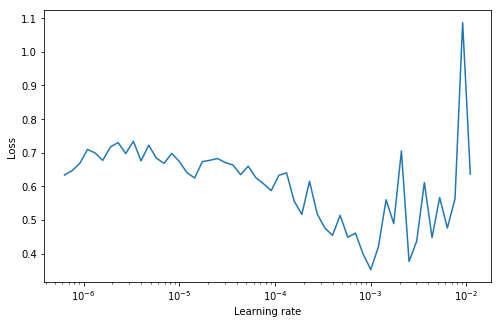

In [19]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(lrs_logs[-1][10:-3], loss_log[10:-3])
ax.set_xscale('log')
ax.set_xlabel('Learning rate')
ax.set_ylabel('Loss');

In [20]:
# second layers split
class HCDNet(nn.Module):
    def __init__(self, net):
        super(HCDNet, self).__init__()
        net_lyrs = [c for n,c in net.named_children()]
        self.backbone1 = nn.Sequential(*net_lyrs[:5])
        self.backbone2 = nn.Sequential(*net_lyrs[5:-2])
        self.classifier = ImgClassifier(net_lyrs[-1].in_features, 1)

    def forward(self, x):
        x = self.backbone1(x)
        x = self.backbone2(x)
        out = self.classifier(x)
        return out

def model_optimizer_init():
    model = HCDNet(copy.deepcopy(pretrained_net))

    params_backbone1 = [p for p in model.backbone1.parameters()]
    params_backbone2 = [p for p in model.backbone2.parameters()]
    params_cls = [p for p in model.classifier.parameters()]

    optimizer = torch.optim.Adam(params=[{'params': params_backbone1}])
    optimizer.add_param_group({'params': params_backbone2})
    optimizer.add_param_group({'params':params_cls})

    return model, optimizer

In [21]:
%%time
model, optimizer = model_optimizer_init()
lrs_logs, loss_log = lr_range_test(train_loader, model.to(device), optimizer, start_lr=(1e-9,1e-8,1e-7), end_lr=(0.1,1,10))
lrs_logs = list(zip(*lrs_logs))

minimum loss 0.30605214834213257, at lr [1.7378008287493764e-05, 0.00017378008287493763, 0.001737800828749376]
CPU times: user 1min 10s, sys: 28.7 s, total: 1min 39s
Wall time: 5min 53s


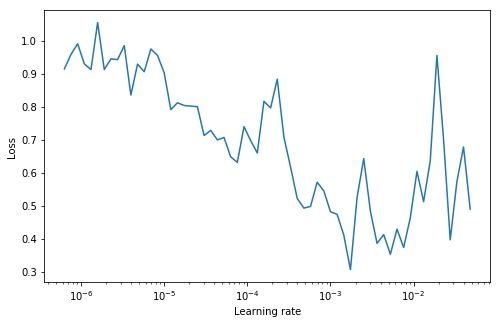

In [22]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(lrs_logs[-1][10:-3], loss_log[10:-3])
ax.set_xscale('log')
ax.set_xlabel('Learning rate')
ax.set_ylabel('Loss');